# Exercises

In [1]:
import pandas as pd

In [15]:
class MyLineReg:
    def __init__(self, n_iter=100, learning_rate=0.1):
        self.n_iter = n_iter
        self.learning_rate = learning_rate
    
    def __str__(self): 
        return f"MyLineReg class: n_iter={self.n_iter}, learning_rate={self.learning_rate}"

In [16]:
a = MyLineReg(10, 0.5)

# Import

In [1]:
import pandas as pd
import numpy as np

from datetime import datetime

import ast
import copy
import matplotlib.pyplot as plt
import re
import seaborn as sns
import warnings

import nltk

from nltk.stem.snowball import SnowballStemmer 

sns.set()
#pd.set_option('max_columns', None)
warnings.filterwarnings('ignore')

# Task Description

I need to predict the price of a used cars based on its features. Obviously, this is a regression problem. As a control metric, I will choose Mean Absolute Percentage Error (MAPE). It is the mean of all absolute percentage errors between the predicted and actual values.
It both easy for end users to understand and simpler to compare model accuracy across use cases and datasets. 

Since the target is the price of a car in the hundreds of thousands of rubles, these values are far from 0, so I can use this metric without worrying about dividing by 0 when calculating the metric.

# Overview

In [2]:
data = pd.read_csv('data/data.csv')
data.head()

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,Владение,ПТС,Привод,Руль,Состояние,Таможня,views,date_added,region,price
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,"['cruise-control', 'multi-wheel', 'xenon', 'he...",Автомобиль приобретался у официального дилера ...,1.8 LTR,180 N12,"{'cruise-control': True, 'asr': True, 'tinted-...",бензин,...,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,76.0,24 сентября,в Тюмени,999000.0
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/rapid/110...,белый,"['cruise-control', 'multi-wheel', 'heated-wash...",Группа компаний Элан Моторс официальный дилер ...,1.6 LTR,110 N12,"{'cruise-control': True, 'glonass': True, 'asr...",бензин,...,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,259.0,24 сентября,в Санкт-Петербурге,1179000.0
2,лифтбек,SKODA,https://auto.ru/cars/new/group/skoda/rapid/217...,белый,"['cruise-control', 'heated-wash-system', 'airb...",Специальные предложения на автомобили в наличи...,1.6 LTR,90 N12,"{'cruise-control': True, 'glonass': True, 'esp...",бензин,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1464100.0
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,"['cruise-control', 'multi-wheel', 'heated-wash...",Купим Ваш автомобиль ДОРОГО Гарантированная с...,1.4 LTR,150 N12,"{'cruise-control': True, 'esp': True, 'usb': T...",бензин,...,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,31.0,25 сентября,в Тюмени,1420000.0
4,внедорожник 5 дв.,SKODA,https://auto.ru/cars/new/group/skoda/karoq/217...,серый,"['cruise-control', 'multi-wheel', 'heated-wash...",ЛОТ 01267595 Скидка на автомобиль при покупке ...,1.4 LTR,150 N12,"{'cruise-control': True, 'asr': True, 'esp': T...",бензин,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2653190.0


In [3]:
data.shape

(130201, 36)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130201 entries, 0 to 130200
Data columns (total 36 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   bodyType              129986 non-null  object 
 1   brand                 129988 non-null  object 
 2   car_url               129969 non-null  object 
 3   color                 129988 non-null  object 
 4   complectation_dict    105267 non-null  object 
 5   description           129988 non-null  object 
 6   engineDisplacement    129988 non-null  object 
 7   enginePower           129988 non-null  object 
 8   equipment_dict        129969 non-null  object 
 9   fuelType              129986 non-null  object 
 10  image                 130065 non-null  object 
 11  mileage               103034 non-null  float64
 12  modelDate             129986 non-null  float64
 13  model_info            0 non-null       float64
 14  model_name            103034 non-null  object 
 15  

In [5]:
data.columns

Index(['bodyType', 'brand', 'car_url', 'color', 'complectation_dict',
       'description', 'engineDisplacement', 'enginePower', 'equipment_dict',
       'fuelType', 'image', 'mileage', 'modelDate', 'model_info', 'model_name',
       'name', 'numberOfDoors', 'parsing_unixtime', 'priceCurrency',
       'productionDate', 'sell_id', 'super_gen', 'vehicleConfiguration',
       'vehicleTransmission', 'vendor', 'Владельцы', 'Владение', 'ПТС',
       'Привод', 'Руль', 'Состояние', 'Таможня', 'views', 'date_added',
       'region', 'price'],
      dtype='object')

In [6]:
data.isnull().sum()

bodyType                   215
brand                      213
car_url                    232
color                      213
complectation_dict       24934
description                213
engineDisplacement         213
enginePower                213
equipment_dict             232
fuelType                   215
image                      136
mileage                  27167
modelDate                  215
model_info              130201
model_name               27167
name                        48
numberOfDoors              214
parsing_unixtime            47
priceCurrency               48
productionDate             213
sell_id                    232
super_gen                   66
vehicleConfiguration       214
vehicleTransmission        215
vendor                  130201
Владельцы                27167
Владение                115915
ПТС                      27167
Привод                   27169
Руль                     27168
Состояние                27169
Таможня                  27171
views   

In [7]:
data.describe()

,mileage,modelDate,model_info,numberOfDoors,parsing_unixtime,productionDate,sell_id,vendor,views,price
count,103034.000000,129986.000000,0.0,129987.000000,1.301540e+05,129988.000000,1.299690e+05,0.0,101998.000000,1.097650e+05
mean,116610.915407,2012.934578,NaN,4.643164,1.632842e+09,2015.083854,1.104866e+09,NaN,564.982284,2.801223e+06
std,85154.492046,6.017749,NaN,0.619354,1.316360e+05,5.929774,1.779786e+06,NaN,1814.036025,2.689068e+06
min,1.000000,1938.000000,NaN,2.000000,1.632613e+09,1952.000000,1.003139e+09,NaN,2.000000,2.300000e+04
25%,51000.000000,2010.000000,NaN,4.000000,1.632725e+09,2012.000000,1.104900e+09,NaN,127.000000,1.000000e+06
50%,100000.000000,2014.000000,NaN,5.000000,1.632821e+09,2016.000000,1.105219e+09,NaN,245.000000,2.045000e+06
75%,161000.000000,2017.000000,NaN,5.000000,1.632973e+09,2020.000000,1.105376e+09,NaN,511.000000,3.649000e+06
max,1000000.000000,2021.000000,NaN,5.000000,1.633049e+09,2021.000000,1.105403e+09,NaN,148149.000000,3.999000e+07


### Subtotal

- There are 130201 rows in this dataset.
- Target "price" contains 20436 missing values. It's bad, because I can't use this examples for model training, so I will remove them.
- Here a lot of categorical features, like as fuelType, brand, color and so on.
- There are description of announcement. It is text data and interesting, will I extract any valuable information from this feature.
- Here two features with links - car_url and image. I will not analyze image links because I will not work with CV techniques in this project. Also I will not use car_url, because I have already a good list of parameters for every case.
- complectation_dict - this feature contains useful information (for example, 'cruise-control', 'multi-wheel' and so on). Moreover, some parameters from this feature are duplicated in the main dataset. Next, I will analyze this feature in more detail.

# Help Functions

In [8]:
'''Text normalization'''
def norm_string(string: str, stemming_flag = 0):
    stemmer = SnowballStemmer("russian") 

    punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~«»»"–+»+"-"”№'''
    string = re.sub('\,|\.|\/|\-', ' ', string)
    string = re.sub('\s+', ' ', string)
    string = [i for i in string if i not in punc] # punc delete
    string = ''.join(string).lower()

    if stemming_flag == 1:
        string = nltk.word_tokenize(string)
        string = [stemmer.stem(w) if len(w) > 6 else w for w in string]
        string = ' '.join(string).lower()

    return string

'''Building of histogram and box plot for numerical features'''
def show_hist_boxplot(feature: pd.Series):
    sns_plot = sns.distplot(feature)
    sns_plot.get_figure()
    plt.show()

    sns.boxplot(y=feature, width=0.4, palette="Greens");
    plt.show()

# Data Preprocessing

In [9]:
# Deleting rows with missing values in target
data = data[data['price'].notna()].reset_index(drop=True)

In [10]:
# Let's remove (little bit later) model_info and vendor features, because they are empty
print(data['model_info'].isna().sum())
print(data['vendor'].isna().sum())

109765
109765


In [11]:
# Data has downloaded in one session. So let's check first value in parsing_unixtime column.
# Date of data parsing is 2021-09-26 
print(data['parsing_unixtime'][0])

1632613481.0


In [12]:
# Feature priceCurrency is constant. Let's remove it
print(data['priceCurrency'].value_counts())

RUB    109765
Name: priceCurrency, dtype: int64


In [13]:
# This feature is unnecessary, because dataset already has this content (body type, transmission, engine displacement). 
# Let's remove it
print(data['vehicleConfiguration'])

0                    LIFTBACK ROBOT 1.8
1                LIFTBACK AUTOMATIC 1.6
2               LIFTBACK MECHANICAL 1.6
3                    LIFTBACK ROBOT 1.4
4         ALLROAD_5_DOORS AUTOMATIC 1.4
                      ...              
109760             SEDAN MECHANICAL 2.0
109761     ALLROAD_5_DOORS VARIATOR 2.4
109762     ALLROAD_5_DOORS VARIATOR 2.0
109763     ALLROAD_5_DOORS VARIATOR 2.4
109764             SEDAN MECHANICAL 1.6
Name: vehicleConfiguration, Length: 109765, dtype: object


In [14]:
# Let's remove this feature, because missing values qty > 88%
print(data['Владение'].isna().sum())
print(f'Missing values qty: {round((data.Владение.isna().sum() / len(data)) * 100, 2)}%')

97597
Missing values qty: 88.91%


In [15]:
# Let's remove this feature, because it contains only one constant value and missing values
print(data['Состояние'].isna().sum())
print(data['Состояние'].value_counts())

21153
Не требует ремонта    88612
Name: Состояние, dtype: int64


In [16]:
# Let's remove this feature, because it contains only one constant value and missing values
print(data['Таможня'].isna().sum())
print(data['Таможня'].value_counts())

21156
Растаможен    88609
Name: Таможня, dtype: int64


In [17]:
# Deleting unnecessary features 
data = data.drop(columns=['car_url', 'image', 'model_info', 'vendor', 'parsing_unixtime', 'priceCurrency', 'vehicleConfiguration', 
                          'Владение', 'Таможня', 'Состояние', 'sell_id'])

In [18]:
data.columns = ['body_type', 'brand', 'color', 'complectation_dict', 'description',
                'engine_displacement', 'engine_power', 'equipment_dict', 'fuel_type',
                'mileage', 'model_date', 'model_name', 'name', 'doors_number',
                'production_date', 'super_gen', 'vehicle_transmission',
                'owners', 'vehicle_passport', 'wheel_drive', 'steering_wheel', 'views', 
                'date_added', 'region', 'price']

### body_type

In [19]:
counts_df = data['body_type'].value_counts().to_frame()
counts_df

,body_type
внедорожник 5 дв.,60847
седан,27685
лифтбек,6192
минивэн,3581
хэтчбек 5 дв.,3183
купе,2666
универсал 5 дв.,1542
компактвэн,1356
пикап двойная кабина,1248
хэтчбек 3 дв.,677


In [20]:
'''Let's replace unpopular body types in df (in comparison with other types) on 'other' type'''
unpopular_types = list(counts_df.loc[counts_df['body_type'] < 100].index)
data['body_type'] = ['other' if i in unpopular_types else i for i in data['body_type'].tolist()]

In [21]:
data['body_type'].value_counts()

внедорожник 5 дв.       60847
седан                   27685
лифтбек                  6192
минивэн                  3581
хэтчбек 5 дв.            3183
купе                     2666
универсал 5 дв.          1542
компактвэн               1356
пикап двойная кабина     1248
хэтчбек 3 дв.             677
фургон                    460
other                     327
Name: body_type, dtype: int64

<AxesSubplot:xlabel='count', ylabel='body_type'>

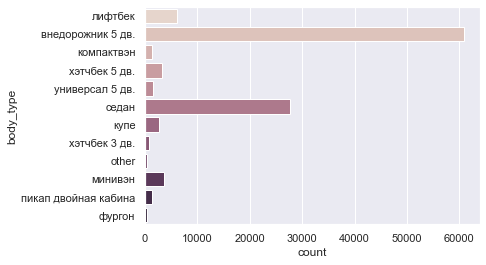

In [22]:
sns.countplot(data=data, y="body_type", palette="ch:.100")

In [23]:
'''Since the length of the dataset is > 109K rows, I can afford to delete one row'''
print('Missing values in body_type:', data['body_type'].isna().sum())
data = data.dropna(axis=0, subset=['body_type']).reset_index(drop=True)

Missing values in body_type: 1


### brand

In [24]:
data['brand'].value_counts().to_frame()

,brand
TOYOTA,16124
MERCEDES,14591
BMW,13743
NISSAN,13463
VOLKSWAGEN,12864
AUDI,9983
MITSUBISHI,8280
SKODA,8241
HONDA,4330
VOLVO,3400


<AxesSubplot:xlabel='count', ylabel='brand'>

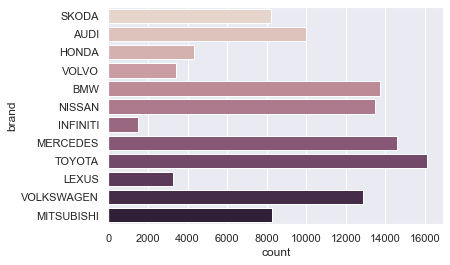

In [25]:
sns.countplot(data=data, y="brand", palette="ch:.100")

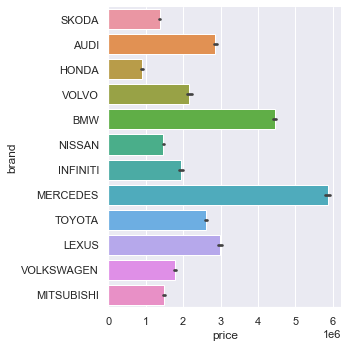

In [26]:
'''Top 3 expensive car brands are Mercedes, BMW and Lexus'''
sns.catplot(data=data, x="price", y="brand", kind="bar")

### color

In [27]:
data['color'].value_counts().to_frame()

,color
чёрный,34600
белый,27212
серый,14656
синий,9717
серебристый,7966
красный,4786
коричневый,3801
бежевый,2443
зелёный,2026
голубой,1241


<AxesSubplot:xlabel='count', ylabel='color'>

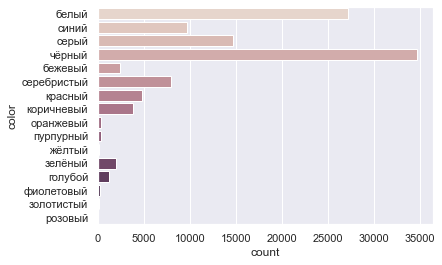

In [28]:
'''Most popular colors are black and white'''
sns.countplot(data=data, y="color", palette="ch:.100")

### fuel_type

In [29]:
counts_df = data['fuel_type'].value_counts().to_frame()
counts_df

,fuel_type
бензин,83931
дизель,24748
гибрид,985
электро,99
газ,1


In [30]:
'''Let's replace unpopular fuel types in df (in comparison with other types) on 'other' type'''
unpopular_types = list(counts_df.loc[counts_df['fuel_type'] < 1000].index)
data['fuel_type'] = ['other' if i in unpopular_types else i for i in data['fuel_type'].tolist()]

In [31]:
data['fuel_type'].value_counts()

бензин    83931
дизель    24748
other      1085
Name: fuel_type, dtype: int64

<AxesSubplot:xlabel='count', ylabel='fuel_type'>

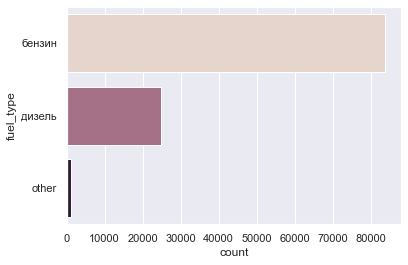

In [32]:
'''Most popular fuel type is gasoline'''
sns.countplot(data=data, y="fuel_type", palette="ch:.100")

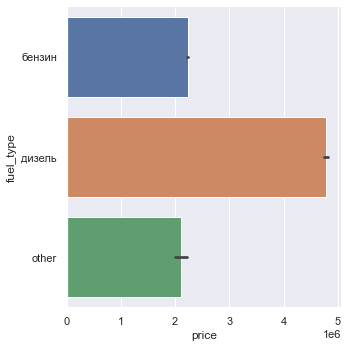

In [33]:
'''But more expensive cars with diesel fuel type'''
sns.catplot(data=data, x="price", y="fuel_type", kind="bar")

### model_name

In [34]:
data['model_name'].value_counts().to_frame()

,model_name
Tiguan,4162
X-Trail,3583
Touareg,2851
Camry,2767
Land Cruiser,2405
...,...
I,1
Succeed,1
Sprinter Carib,1
Carina ED,1


In [35]:
'''There are a lot of missing values in this feature, so it's a good idea to remove it. But for now, I won't do it'''
data['model_name'].isna().sum()

21152

### name

In [36]:
'''This feature contains information about brand, model and something else.
Let's try to extract car model from this feature. I parsed car models manually and keep them in brand_dict.
I'm fixing the car model if model from brand_dict contains in the feature name'''
data['name']

0                        Skoda Octavia III (A7)
1                                Skoda Rapid II
2                                Skoda Rapid II
3             Skoda Octavia III (A7) Рестайлинг
4                                 Skoda Karoq I
                          ...                  
109759                      Mitsubishi Lancer X
109760      Mitsubishi Outlander III Рестайлинг
109761    Mitsubishi Outlander III Рестайлинг 3
109762       Mitsubishi Outlander II Рестайлинг
109763           Mitsubishi Lancer X Рестайлинг
Name: name, Length: 109764, dtype: object

In [37]:
brand_dict = {
    'skoda': ['Citigo', 'Rapid', 'Octavia', 'Fabia', 'Superb', 'Kodiaq', 'Karoq', 'Scala', 'Kamiq', 'Enyaq', 'Kushaq', 'Slavia', 'Yeti', 'Felicia',
             'Roomster', 'Favorit', '105'],
    
    'audi': ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'Cabriolet', 'TT', 'Coupe', 'Roadster', 'Q2', 'Q3', 'Q5', 'Q7', 'R8', 'e-tron', 'R8', 
             'Sportback', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'SQ2', 'SQ5', 'SQ7', 'TTS', '100', '200', '80', '90', 'e', 'q8', 'rs', 'sq8', 'v8'],
    
    'honda': ['Accord', 'Avancier', 'City', 'Civic', 'Concerto', 'CR-V', 'CR-X', 'CR-Z', 'Crossroad', 'Crosstour', 'Element', 'Elevate', 'Elysion', 
              'Clarity', 'Fit', 'FR-V', 'Freed', 'Grace', 'HR-V', 'Integra', 'S660', 'Vigor', 'Insight', 'Insight', 'Jazz', 'Legend', 'Logo', 'Slash', 
              'N-ONE', 'N-WGN', 'NSX', 'Odyssey', 'Orthia', 'Pilot', 'Prelude', 'Rafaga', 'Ridgeline', 'S-MX', 'S2000', 'Shirui', 'Shuttle', 'Stream',
              'Torneo', 'Zest', 'ZR-V', 'stepwgn', 'acty', 'airwave', 'ascot', 'capa', 'cr', 'domani', 'edix', 'fr', 'hr', 'inspire', 'jade', 'life', 
              'mobilio', 'n', 'partner', 's', 'saber', 'stepwgn', 'today', 'vamos', 'vezel', 'z'],
    
    'volvo': ['66', '140', '200', '300', '460', '480', '700', '850', '900', '940', '960', 'Amazon', 'Brage', 'C30', 'C70', 'C202', 'EX30', 'EX90', 'F4', 
              'F10', 'F85', 'F88', 'FE', 'FH', 'FL', 'FM', 'FMX', 'L340', 'Longnose', 'LV4', 'LV60', 'LV66', 'LV71', 'LV76', 'LV81', 'LV120', 'PV4', 
              'P1800', 'P1900', 'Carioca', 'PV444', 'S40', 'S60', 'S70', 'S80', 'S90', 'Sharpnose', 'Snabbe', 'T6', 'Titan', 'V60', 'Viking', 'VM', 'VN', 
              'VHD', 'VT', 'XC40', 'XC60', 'V70', 'XC90', '240', '440', '740', '760', 'v40', 'v50', 'v90', 'xc70'],
    
    'bmw': ['328', '501', '503', '507', '700', '3200', 'ActiveHybrid', 'E3', 'E9', 'E12', 'E21', 'E23', 'E24', 'E28', 'E30', 'E31', 'E32', 'E34', 'E34', 
            'E36', 'E38', 'E39', 'E46', 'E60', 'E65', 'E87', 'E90', 'E92', 'F01', 'F10', 'F22', 'F23', 'F26', 'F30', 'F34', 'F82', 'G02', 'G11', 'G15', 
            'G20', 'G30', 'G60', 'G70', 'G82', 'GINA', 'Hydrogen', 'Vision', 'i3', 'i7', 'i8', 'Isetta', 'iX', 'M1', 'M3', 'M5', 'M6', 'Klasse', 'X', 
            'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'XM', 'Z', 'Z1', 'Z4', 'Z8', 'm2', 'm8', 'z3', '320d', 'gran', '330i', '645i', 'f87', '318i', 
            '640d', '640i','116d', '116i', '118i', '120d', '135i', '316d', '316i', '318d', '320i', '328i', '330d', '335i', '420d', '420i', '428i', 
            '430i', '435i', '630i', '650i', 'active', 'm340i'],
    
    'nissan': ['180SX', '300ZX', '350Z', '370Z', 'Almera', 'Hybrid', 'Armada', 'Atlas', 'Atleon', 'Avenir', 'Thumb', 'Bluebird', 'Sylphy', 'C80', 'Caball', 
               'Caravan', 'Elgrand', 'Cedric', 'Cefiro', 'Condor', 'Cube', 'Cherry', 'DeltaWing', 'Z', 'Figaro', 'Fuga', 'Gloria', 'GT-R', 'Nismo', 'Truck', 
               'II', 'Juke', 'Kicks', 'Laurel', 'Spirit', 'LEAF', 'Leopard', 'Liberty', 'Livina', 'Logan', 'Magnite', 'Maxima', 'Micra', 'Mixim', 'Murano', 
               'Navara', 'NP300', 'NT400', 'NT500', 'NV200', 'NV250', 'NV400', 'III', 'Pao', 'Pathfinder', 'Patrol', 'Pintara', 'Pivo', 'A-Star', 'Presage', 
               'President', 'Primera', 'Homer', 'Royal', 'Pulsar', 'GTI-R', 'Qashqai', 'Quest', 'Quon', 'R’nessa', 'Rasheen', 'Project', 'S30', 'Sakura', 
               'Sentra', 'Serena', 'Silvia', 'Skyline', 'Stagea', 'Stanza', 'Sunny', 'Wagon', 'Teana', 'Terrano', 'Tiida', 'Titan', 'Townstar', 'Trade', 
               'Truck', 'Vanette', 'Wingroad', 'X-Trail', 'Xterra', 'bassara', 'dayz', 'dualis', 'expert', 'gt', 'kix', 'march', 'note', 'nv100', 
               'qashqai2', 'rnessa', 'tino', 'x'],
    
    'infiniti': ['Q50', 'Q60', 'Q70', 'QX30', 'QX50 ', 'QX60', 'QX80', 'M30', 'M45', 'G20', 'J30', 'QX4', 'I', 'Q45', 'FX35', 'QX56', 'QX70', 'G25', 
                 'G35', 'G37', 'fx', 'jx', 'm', 'q30', 'qx50', 'qx55'],
    
    'mercedes': ['300SL', '500K', '770', 'R129', 'A-класс', 'GT', 'Atron', 'B-класс', 'Patent-Motorwagen', 'C-класс', 'C111', 'C215', 'C218', 'w188',
                 'C219', 'C112', 'C117', 'C257', 'Citan', 'CL-класс', 'CLA-класс', 'CLC-класс', 'GTR', 'CLS-класс', 'E-класс', 'SUV', 'F-Cell', 'G-класс', 
                 'G4', 'GLB-класс', 'GLE-класс', 'GLK-класс', 'GLS-класс', 'MB100', 'D', 'SLR', '6.3', '6.9', 'AMG', 'V167', 'X167', 'L206', 'E7.4RS', 
                 'TN', 'Vaneo', 'W108', 'W111', 'W112', 'W180', 'R171', 'R-класс', 'ONE', 'R107', 'C107', 'R170', 'R172', 'R230', 'R231', 'S', 'S-класс', 
                 'McLaren', 'SL-класс', 'AMG', 'SLC-класс', 'SLK-класс', 'AMG', 'Sprinter', 'T80', 'Т-класс', 'Transporter', '300', 'b', 'cl', 'w128',
                 'V-класс', 'W21', 'W212', 'CLK-класс', 'W100', 'W109', 'W110', 'W113', 'W114', 'W115', 'W116', '190SL', 'W120', 'W123', 'W124', 'eqc',
                 'Rekordwagen', 'W126', 'W136', 'W140', 'W143', 'W163', 'W164', 'W166', 'W177', 'W194', 'W198', 'W201', 'W202', 'W203', 'W204', 'cl',
                 'W205', 'W208', 'W209', 'W210', 'W211', 'W213', 'W214', 'W220', 'W221', 'W222', 'W223', 'W245', 'W246', 'W251', 'W460', 'W463', 'glb', 
                 'Vito', 'W901', 'W906', 'W907', 'X-класс', 'GLA-класс', 'X164', 'X166', 'maybach', 'glc', 'gla', 'gle', 'glk', 'viano', 'clc', 'cla', 'a',
                 'w638'],
    
    'toyota': ['4Runner', '2000GT', 'AA', 'AE86', 'Agya', 'Allion', 'Alphard', 'Aqua', 'Aurion', 'Auris', 'Avalon', 'Avensis', 'Aygo', 'X', 'bB', 
               'Belta', 'Brevis', 'bZ3', 'Caldina', 'Camry', 'Solara', 'Carina', 'ED', 'Celica', 'Camry', 'GT-Four', 'Century', 'CH-R', 'Chaser', 'Corolla', 
               'E140', 'E170', 'Cross', 'Spacio', 'Corona', 'Cressida', 'Cresta', 'Crown', 'Majesta', 'Curren', 'Cynos', 'Duet', 'Dyna', 'eCom', 'Fine-N', 
               'Fine-X', 'Cruiser', 'Fortuner', 'FT-HS', 'Gaia', 'Highlander', 'Harrier', 'Hiace', 'Highlander', 'Hilux', 'X', 'Ipsum', 'iQ', 'Isis', 'iX4', 
               'Cruiser', 'Prado', 'LiteAce', 'II', 'Qualis', 'X', 'Matrix', 'Mirai', 'MR2', 'Nadia', 'Noah', 'Opa', 'Passo', 'Picnic', 'Epoch', 'Space', 'PM', 
               'Porte', 'Premio', 'Previa', 'Prius','PHV', 'α', 'ProAce', 'Probox', 'Progres', 'Publica', 'Ractis', 'Raum', 'RAV4', 'EV', 'Rush', 'SA', 
               'SAI', 'Sequoia', 'Sienna', 'Soarer', '800', 'Sprinter', 'Marino', 'Stout', 'Succeed', 'Supra', 'Tacoma', 'Tercel', 'Ace', 'Toyoace', 
               'Avanza', 'Hybrid', 'Cross', 'Hybrid', 'Tundra', 'Cruiser', 'Venza', 'Verossa', 'Vista', 'V20', 'Wish', 'Yaris', 'allex', 'c', 
               'cavalier', 'esquire', 'estima', 'funcargo', 'platz', 'regius', 'sienta', 'spade', 'starlet', 'verso', 'vitz', 'voxy', 'windom'],
    
    'lexus': ['ES', 'LS', 'LX', 'GX', 'NX', 'RX', 'UX', 'ct', 'gs', 'hs', 'is', 'lc', 'rc', 'sc'], 

    'volkswagen': ['Golf', 'CrossFox', 'Eos', 'GLI', 'Gol', 'Golf', 'GTI', 'Jetta', 'Wagon', 'Beetle', 'Passat', 'CC', 'Routan', 'SportVan', 'Tiguan', 
                   'Touareg', 'Caddy', 'Fox', 'Gol', 'GTI', 'Parati', 'Polo', 'Saveiro','amarok', 'arteon', 'bora', 'california', 'caravelle', 
                   'multivan', 'phaeton', 'pointer', 'scirocco', 'sharan', 'taos', 'teramont', 'touran', 'transporter', 'type'],
    
    'mitsubishi': ['ASX', 'Attrage', 'Carisma', 'Delica', 'Diamante', 'Dingo', 'Dion', 'E-More', 'Eclipse', 'Endeavor', 'Eupheme', 'EV', 'Galant', 'Lambda', 
                   'Jingang', 'Jeep', 'L200', 'Lancer', 'Evolution', 'Minica', 'Mirage', '500', 'Cross', 'Canter', 'Fighter', 'Rosa', 'Great', 'HSR', 'Magna', 
                   'Minicab', 'Raider', 'Outlander', 'Pajero', 'Mini', 'Sport', 'Runner', 'Star', 'Starion', 'Box', 'Tredia', '73', 'Harrier', 'Hiace', 
                   'Highlander', 'Hilux', 'X', 'Ipsum', 'iQ', 'Isis', 'iX4', 'Cruiser', 'Prado', 'LiteAce', 'II', 'Qualis', 'X', 'Matrix', 'Mirai', 'MR2', 'Nadia',  
                   'Opa', 'Passo', 'Picnic', 'Epoch', 'Space', 'PM', 'Porte', 'Premio', 'Previa', 'Prius', 'PHV', 'ProAce', 'Probox', 'Progres', 'Publica', 
                   'Ractis', 'Raum', 'RAV4', 'EV', 'Rush', 'SA', 'SAI', 'Sequoia', 'Sienna', 'Soarer', '800', 'Sprinter', 'Marino', 'Stout', 'Succeed', 'Supra', 
                   'Tacoma', 'Tercel', 'Ace', 'Toyoace', 'Avanza', 'Hybrid', 'Cross', 'Hybrid', 'Tundra', 'Cruiser', 'Venza', 'Verossa', 'Vista', 'V20', 
                   'Wish', 'Yaris', 'Noah', '3000', 'airtrek', 'challenger', 'chariot', 'colt', 'ek', 'eterna', 'fto', 'grandis', 'i', 'l400', 'legnum', 
                   'libero', 'montero', 'rvr', 'toppo']
}

In [38]:
norm_name_list = [norm_string(s).split(' ') for s in data['name'].tolist()]
model_list = []
none_list = []

for s, norm_name in enumerate(norm_name_list):
    brand = norm_string(data['brand'][s])
    brand_model_list = brand_dict.get(brand)

    model = [a for a in brand_model_list if norm_string(a) in norm_name]
    
    if model:
        model_list.append(model[0])

    else:
        model_list.append(None)
        none_list.append(norm_name)

In [39]:
print(len(none_list), none_list)

1 [['mercedes', 'benz', 'r', 'класс', '350', 'long', 'i']]


In [40]:
'''Let's replace missing values in model_name feature by extracted values from name feature'''
data['model_name'] = [i if str(i) != 'nan' else model_list[s] for s, i in enumerate(data['model_name'].tolist())]
data['model_name'] = data['model_name'].apply(lambda x: norm_string(x))
data['model_name'].isna().sum()

0

In [41]:
data['model_name'].value_counts().to_frame()

,model_name
tiguan,4710
a6,3636
x trail,3583
camry,3372
outlander,3217
...,...
esquire,1
bassara,1
vellfire,1
edix,1


In [42]:
'''Let's remove name feature'''
data = data.drop(columns=['name'])

### engine_power

In [43]:
data['engine_power'].head()

0    180 N12
1    110 N12
2     90 N12
3    150 N12
4    150 N12
Name: engine_power, dtype: object

In [44]:
'''Let's check idea that N12 is static for every value. Yes, it's true'''
set([i.split(' ')[1] for i in data['engine_power'].tolist()])

{'N12'}

In [45]:
'''Let's remove static part with N12 in every value of feature'''
data['engine_power'] = [i.split(' ')[0] for i in data['engine_power'].tolist()]
data['engine_power'] = data['engine_power'].astype(int)

In [46]:
'''Ok, this categorical feature contains 302 unique values, it's so much for the next operations with ML'''
print('Min value:', data['engine_power'].min())
print('Max value:', data['engine_power'].max())
print('Unique values qty:', data['engine_power'].value_counts().shape[0])

data['engine_power'].value_counts().to_frame().head(15)

Min value: 41
Max value: 646
Unique values qty: 302


,engine_power
249,12225
150,8351
190,6291
181,3121
110,3041
144,2882
171,2787
170,2771
180,2618
146,2205


<AxesSubplot:xlabel='engine_power', ylabel='Count'>

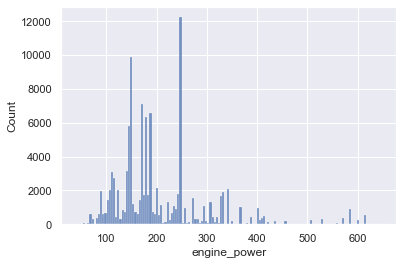

In [50]:
'''Most cars with engine power ~ 250 and ~150'''
sns.histplot(data=data, x="engine_power")

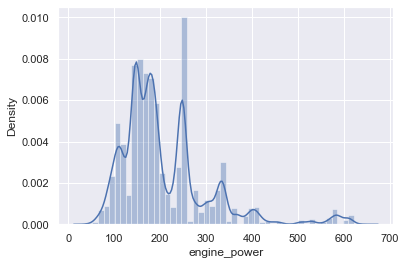

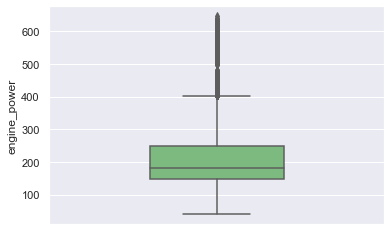

In [48]:
show_hist_boxplot(data['engine_power'])

In [56]:
'''Let's bucketize this numerical feature for 6 classes. 
Since the distribution of the feature is uneven, I use buckets with quantile boundaries'''
data['engine_power'] = pd.qcut(data['engine_power'], q=6)
data['engine_power'].value_counts()

In [48]:
'''Let's split this feature into 6 classes'''
'''class_list = []
brink_values = [0, 140, 240, 340, 440, 540]

for s in data['engine_power'].tolist():
    class_list.append([i for i, j in enumerate(brink_values) if s > j][-1])

data['engine_power'] = class_list
sns.countplot(data=data, x="engine_power", palette="ch:.100")'''

### doors_number

In [58]:
data['doors_number'] = data['doors_number'].astype(int)
data['doors_number'].value_counts()

5    75164
4    30619
2     2867
3     1114
Name: doors_number, dtype: int64

### owners

In [59]:
'''Quarter of all values missed'''
print('Missing values qty:', data['owners'].isna().sum())

data['owners'].value_counts()

Missing values qty: 21152


1 владелец     33304
3 или более    30916
2 владельца    24392
Name: owners, dtype: int64

<AxesSubplot:xlabel='owners', ylabel='count'>

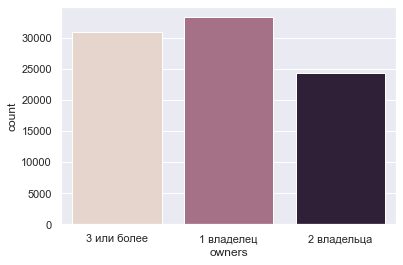

In [60]:
sns.countplot(data=data, x="owners", palette="ch:.100")

In [61]:
'''I won't fill missing values with most popular class, because it's almost uniform distribution with only 3 classes.
Let's create 4th class "other"'''
data['owners'] = data['owners'].fillna('other')

In [62]:
data['owners'].value_counts()

1 владелец     33304
3 или более    30916
2 владельца    24392
other          21152
Name: owners, dtype: int64

### vehicle_transmission

In [63]:
'''Here everything is ok. I'll use One Hot Encoding for this feature later'''
data['vehicle_transmission'].value_counts()

автоматическая      64300
вариатор            19988
роботизированная    13941
механическая        11535
Name: vehicle_transmission, dtype: int64

### vehicle_passport

In [64]:
print('Missing values qty:', data['vehicle_passport'].isna().sum())

data['vehicle_passport'].value_counts()

Missing values qty: 21152


Оригинал    78803
Дубликат     9809
Name: vehicle_passport, dtype: int64

In [65]:
'''This feature contains 21152 of missing values and only 2 classes, where one of them is more popular than other one.
Let's remove it'''
data = data.drop(columns = ['vehicle_passport'])

### wheel_drive

In [66]:
print('Missing values qty:', data['wheel_drive'].isna().sum())

data['wheel_drive'].value_counts()

Missing values qty: 21152


полный      51288
передний    31145
задний       6179
Name: wheel_drive, dtype: int64

### engine_displacement

In [67]:
data['engine_displacement'].head()

0    1.8 LTR
1    1.6 LTR
2    1.6 LTR
3    1.4 LTR
4    1.4 LTR
Name: engine_displacement, dtype: object

In [68]:
data['engine_displacement'] = data['engine_displacement'].apply(lambda x: x.split()[0])

In [69]:
print('Missing values with "LTR":', len(data[data['engine_displacement'] == 'LTR']))

Missing values with "LTR": 99


In [70]:
top_value = data['engine_displacement'].describe()['top']
data['engine_displacement'] = [top_value if i == 'LTR' else i for i in data['engine_displacement'].tolist()]
data['engine_displacement'] = data['engine_displacement'].astype(float)

In [71]:
data['engine_displacement']

0         1.8
1         1.6
2         1.6
3         1.4
4         1.4
         ... 
109759    2.0
109760    2.4
109761    2.0
109762    2.4
109763    1.6
Name: engine_displacement, Length: 109764, dtype: float64

<AxesSubplot:xlabel='count', ylabel='engine_displacement'>

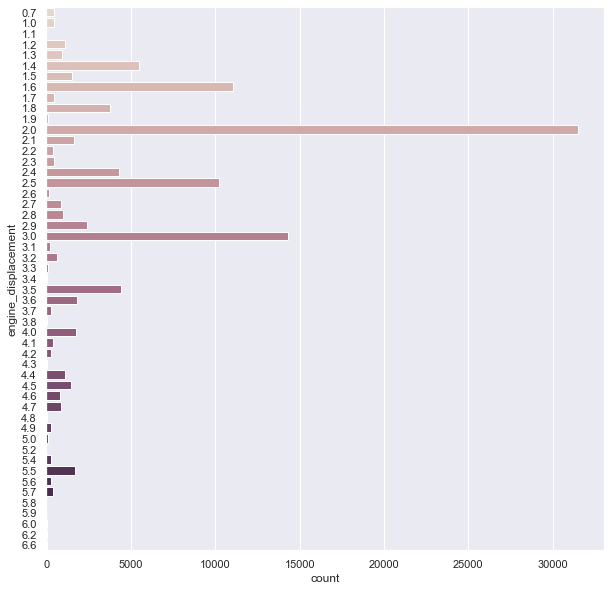

In [72]:
fig, ax = plt.subplots(figsize=(10,10))
sns.countplot(data=data, y="engine_displacement", palette="ch:.100", ax=ax)

### equipment_dict

In [73]:
data['equipment_dict'][0]

"{'cruise-control': True, 'asr': True, 'tinted-glass': True, 'esp': True, 'adaptive-light': True, 'usb': True, 'multi-wheel': True, 'xenon': True, 'audiosystem-tv': True, 'heated-wash-system': True, 'ashtray-and-cigarette-lighter': True, 'airbag-passenger': True, 'front-centre-armrest': True, 'lock': True, 'door-sill-panel': True, 'servo': True, 'electro-mirrors': True, 'drl': True, 'electro-window-back': True, 'feedback-alarm': True, 'mirrors-heat': True, 'volume-sensor': True, '17-inch-wheels': True, 'dark-interior': True, 'park-assist-f': True, 'combo-interior': True, 'rear-seats-heat': True, 'cooling-box': True, 'seat-memory': True, 'music-super': True, 'park-assist-r': True, 'engine-proof': True, 'start-stop-function': True, 'airbag-driver': True, 'isofix': True, 'aux': True, 'drive-mode-sys': True, 'electro-window-front': True, 'light-sensor': True, 'hcc': True, 'automatic-lighting-control': True, 'airbag-curtain': True, 'passenger-seat-updown': True, 'computer': True, 'seat-tran

In [74]:
data['equipment_dict'] = data['equipment_dict'].apply(lambda x: ast.literal_eval(x))
data['equipment_dict'].head()

0    {'cruise-control': True, 'asr': True, 'tinted-...
1    {'cruise-control': True, 'glonass': True, 'asr...
2    {'cruise-control': True, 'glonass': True, 'esp...
3    {'cruise-control': True, 'esp': True, 'usb': T...
4    {'cruise-control': True, 'asr': True, 'esp': T...
Name: equipment_dict, dtype: object

In [75]:
data['equipment_dict'].head(10)

0    {'cruise-control': True, 'asr': True, 'tinted-...
1    {'cruise-control': True, 'glonass': True, 'asr...
2    {'cruise-control': True, 'glonass': True, 'esp...
3    {'cruise-control': True, 'esp': True, 'usb': T...
4    {'cruise-control': True, 'asr': True, 'esp': T...
5    {'cruise-control': True, 'asr': True, 'esp': T...
6    {'steel-wheels': True, 'esp': True, 'airbag-dr...
7    {'cruise-control': True, 'glonass': True, 'esp...
8    {'cruise-control': True, 'asr': True, 'tinted-...
9    {'cruise-control': True, 'asr': True, 'esp': T...
Name: equipment_dict, dtype: object

In [76]:
'''It's very interesting feature, because it contains dictionaries with a lot of binary characteristics.
For example, "cruise-control", "airbag-passenger", "navigation" and so on. It contains only True values. 
I'll choose important characteristics of car in my opinion and include them to main dataframe.
If feature doesn't contain characteristic I'll put False'''
print(data['equipment_dict'][0])

{'cruise-control': True, 'asr': True, 'tinted-glass': True, 'esp': True, 'adaptive-light': True, 'usb': True, 'multi-wheel': True, 'xenon': True, 'audiosystem-tv': True, 'heated-wash-system': True, 'ashtray-and-cigarette-lighter': True, 'airbag-passenger': True, 'front-centre-armrest': True, 'lock': True, 'door-sill-panel': True, 'servo': True, 'electro-mirrors': True, 'drl': True, 'electro-window-back': True, 'feedback-alarm': True, 'mirrors-heat': True, 'volume-sensor': True, '17-inch-wheels': True, 'dark-interior': True, 'park-assist-f': True, 'combo-interior': True, 'rear-seats-heat': True, 'cooling-box': True, 'seat-memory': True, 'music-super': True, 'park-assist-r': True, 'engine-proof': True, 'start-stop-function': True, 'airbag-driver': True, 'isofix': True, 'aux': True, 'drive-mode-sys': True, 'electro-window-front': True, 'light-sensor': True, 'hcc': True, 'automatic-lighting-control': True, 'airbag-curtain': True, 'passenger-seat-updown': True, 'computer': True, 'seat-trans

In [77]:
selected_features = ['cruise-control', 'electro-mirrors', 'computer', 'navigation', 'rain-sensor', 'alarm', 'auto-mirrors']

for f in selected_features:
    data[re.sub('-', '_', f)] = [True if i.get(f) is not None else False for i in data['equipment_dict'].tolist()]

data['climate_control'] = [True if [s for s in list(i.keys()) if 'climate-control' in s] else False for i in data['equipment_dict'].tolist()]
data['airbag'] = [True if [s for s in list(i.keys()) if 'airbag' in s] else False for i in data['equipment_dict'].tolist()]
data['audio'] = [True if [s for s in list(i.keys()) if 'music' in s or 'audio' in s] else False for i in data['equipment_dict'].tolist()]

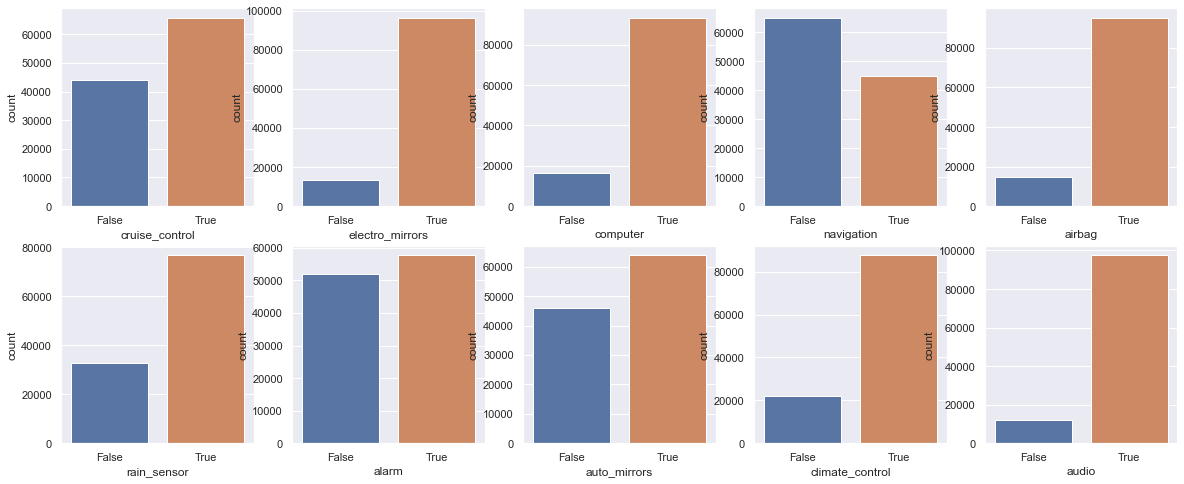

In [78]:
fig, ax = plt.subplots(2,5, figsize=(20,8))

sns.countplot(data=data, x='cruise_control', ax=ax[0,0])
sns.countplot(data=data, x='electro_mirrors', ax=ax[0,1])
sns.countplot(data=data, x='computer', ax=ax[0,2])
sns.countplot(data=data, x='navigation', ax=ax[0,3])
sns.countplot(data=data, x='airbag', ax=ax[0,4])

sns.countplot(data=data, x='rain_sensor', ax=ax[1,0])
sns.countplot(data=data, x='alarm', ax=ax[1,1])
sns.countplot(data=data, x='auto_mirrors', ax=ax[1,2])
sns.countplot(data=data, x='climate_control', ax=ax[1,3])
sns.countplot(data=data, x='audio', ax=ax[1,4])

fig.show()

### steering_wheel

In [79]:
print('Missing values qty:', data['steering_wheel'].isna().sum())

data['steering_wheel'].value_counts()

Missing values qty: 21153


Левый     85551
Правый     3060
Name: steering_wheel, dtype: int64

In [80]:
data = data.drop(columns=['steering_wheel'])

### mileage

In [81]:
print('Missing values qty:', data['mileage'].isna().sum())

Missing values qty: 21152


### date_added

In [82]:
'''This feature shows date when the ad for sale was published.
Latest date actually indicates to date of data parsing.
Also, I know the data was parsed in September 2021, so dates without a year are 2021.'''
print('Missing values qty:', data['date_added'].isna().sum())

data['date_added'].value_counts().to_frame()

Missing values qty: 21152


,date_added
25 сентября,38377
26 сентября,6403
27 сентября,5889
24 сентября,4631
29 сентября,4624
...,...
9 ноября 2018,1
26 сентября 2019,1
28 сентября 2018,1
27 августа 2018,1


In [83]:
'''Let's add 2021 year to dates without year'''
data['date_added'] = [i + ' 2021' if re.search('20\d{2}', str(i).split()[-1]) is None and str(i) != 'nan' else i for i in data['date_added'].tolist()]

In [84]:
data['date_added']

0         24 сентября 2021
1         24 сентября 2021
2                      NaN
3         25 сентября 2021
4                      NaN
                ...       
109759    25 сентября 2021
109760    30 сентября 2021
109761                 NaN
109762    25 сентября 2021
109763    30 сентября 2021
Name: date_added, Length: 109764, dtype: object

In [85]:
'''Names and numbers of monthes'''
month_dict = {
    'января': '1',
    'февраля': '2',
    'марта': '3',
    'апреля': '4',
    'мая': '5',
    'июня': '6',
    'июля': '7',
    'августа': '8',
    'сентября': '9',
    'октября': '10',
    'ноября': '11',
    'декабря': '12',
}

In [86]:
'''Let's replace monthes words to numbers'''
data['date_added'] = [i.split()[0] + '.' + month_dict.get(i.split()[1]) + '.' + i.split()[2] if str(i) != 'nan' else i for i in data['date_added'].tolist()]

'''Converting string dates to datetime format'''
data['date_added'] = data['date_added'].apply(lambda x: datetime.strptime(x, '%d.%m.%Y').date() if str(x) != 'nan' else x)
data['date_added'][0]

datetime.date(2021, 9, 24)

In [87]:
data['date_added'].value_counts()

2021-09-25    38377
2021-09-26     6403
2021-09-27     5889
2021-09-24     4631
2021-09-29     4624
              ...  
2018-11-09        1
2019-09-26        1
2018-09-28        1
2018-08-27        1
2019-05-27        1
Name: date_added, Length: 920, dtype: int64

In [88]:
parsing_date = max([i for i in data['date_added'].tolist() if str(i) != 'nan'])
print('Date of data parsing is', parsing_date)

'''Let's fill missing values in date_added by parsing_date'''
data['date_added'] = data['date_added'].fillna(parsing_date)

Date of data parsing is 2021-09-30


### model_date

In [89]:
data['model_date'].head()

0    2013.0
1    2020.0
2    2020.0
3    2017.0
4    2017.0
Name: model_date, dtype: float64

In [90]:
'''Let's create a new feature "model_age" based on "model_date"'''
data['model_age'] = parsing_date.year - data['model_date']
data['model_age']

0          8.0
1          1.0
2          1.0
3          4.0
4          4.0
          ... 
109759    14.0
109760     7.0
109761     3.0
109762    12.0
109763    10.0
Name: model_age, Length: 109764, dtype: float64

In [91]:
data = data.drop(columns=['model_date'])

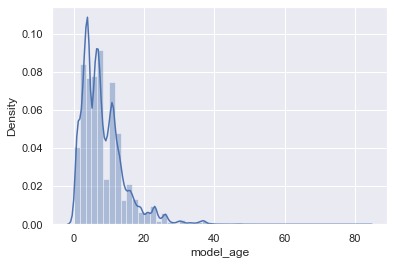

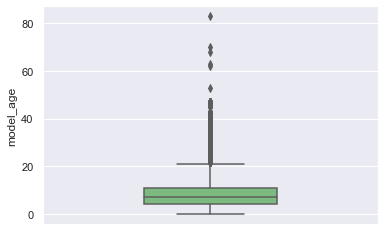

In [92]:
'''Let's see on distribution and outliers of this feature'''
show_hist_boxplot(data['model_age'])

In [93]:
'''The distribution is uneven and shifted to the left. Model age > 60 years is unusual. Let's see on this examples.
It's appropriate ages for this car models'''
data.loc[data['model_age'] > 60]

,body_type,brand,color,complectation_dict,description,engine_displacement,engine_power,equipment_dict,fuel_type,mileage,...,electro_mirrors,computer,navigation,rain_sensor,alarm,auto_mirrors,climate_control,airbag,audio,model_age
55502,купе,MERCEDES,зелёный,NaN,Автомобиль приобретался у официального дилера ...,2.8,2,"{'electro-window-back': True, 'condition': Tru...",бензин,84369.0,...,False,False,False,False,False,False,False,False,False,62.0
55933,other,MERCEDES,коричневый,NaN,1959 Mercedes Benz 220 SE Более известный как ...,2.2,0,{},бензин,50000.0,...,False,False,False,False,False,False,False,False,False,63.0
56560,other,MERCEDES,чёрный,NaN,Mercedes Benz 220 Cabriolet A 1952 W187 Благод...,3.0,1,{},бензин,64200.0,...,False,False,False,False,False,False,False,False,False,70.0
90522,купе,VOLKSWAGEN,синий,NaN,Все сделано кроме покраски,1.6,0,{},бензин,45000.0,...,False,False,False,False,False,False,False,False,False,83.0
104289,other,MITSUBISHI,зелёный,NaN,В хорошем состоянии,2.0,0,{},бензин,100000.0,...,False,False,False,False,False,False,False,False,False,68.0


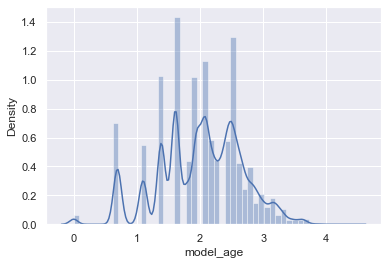

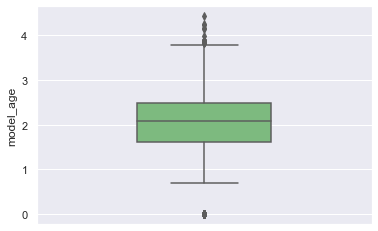

In [94]:
'''There are extreme values and data distribution is skewed. Let's normalize this feature using logarithm. 
Distribution has become a little better. But it still is not good'''
show_hist_boxplot(np.log(data['model_age'] + 1))

In [99]:
'''Let's use bucketing for normalization of the feature. 
Since the distribution is skewed, I'm using specifically quantile bucketing'''

data['model_age'] = pd.qcut(data['model_age'], q=10, labels=[i for i in range(10)])
data['model_age'].value_counts()

3    14176
2    13928
0    12784
7    12566
4    10990
8    10348
6     9960
1     9943
9     9371
5     5698
Name: model_age, dtype: int64

### production_date

In [102]:
data['production_date'].head()

0    2015.0
1    2020.0
2    2021.0
3    2018.0
4    2021.0
Name: production_date, dtype: float64

In [103]:
'''Let's create a new feature "car_age" based on "production_date"'''
data['production_date'] = parsing_date.year - data['production_date']
data = data.rename(columns={"production_date": "car_age"})

0          6.0
1          1.0
2          0.0
3          3.0
4          0.0
          ... 
109759    14.0
109760     7.0
109761     0.0
109762    10.0
109763     7.0
Name: production_date, Length: 109764, dtype: float64

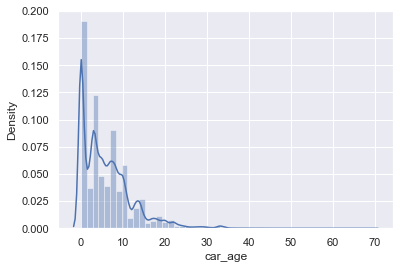

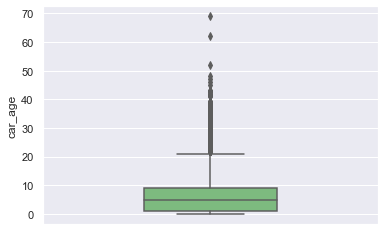

In [111]:
show_hist_boxplot(data['car_age'])

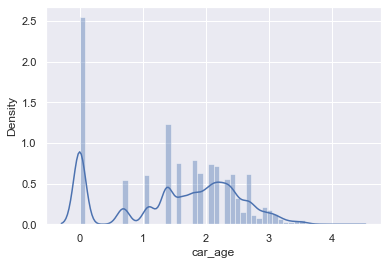

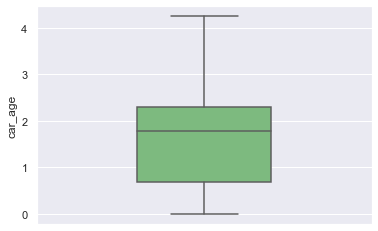

In [110]:
'''There are extreme values and data distribution is skewed. Let's normalize this feature using logarithm. 
Distribution has become a little better. But it still is not good'''
show_hist_boxplot(np.log(data['car_age'] + 1))

In [141]:
'''Let's use bucketing for normalization of the feature. 
Since the distribution is skewed, I'm using specifically quantile bucketing'''

data['car_age'] = pd.qcut(data['car_age'].astype(int), q=10, duplicates='drop')
data['car_age'].value_counts()

(-0.001, 2.0]    34470
(3.0, 5.0]       14324
(6.0, 8.0]       13665
(2.0, 3.0]       11557
(8.0, 10.0]      10962
(10.0, 14.0]     10161
(14.0, 69.0]      8758
(5.0, 6.0]        5867
Name: car_age, dtype: int64

### views

In [166]:
data['views'].isna().sum()

22084

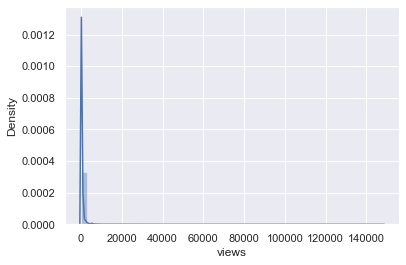

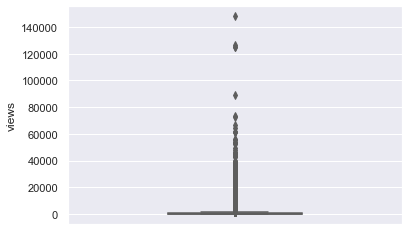

In [167]:
show_hist_boxplot(data['views'])

In [175]:
'''This feature has 22084 missing values. I would be to replace them in popular value, but it's needed to analyze ad age additionally.
Or I would be just delete it, but I guess this feature is important for target'''
data['views'].describe()

count     87680.000000
mean        583.094172
std        1910.160359
min           2.000000
25%         124.000000
50%         241.000000
75%         521.000000
max      148149.000000
Name: views, dtype: float64

In [226]:
'''Correlation of "views" and "price" is minimal. So I just delete this feature'''
sub_data = data.loc[data['views'].astype(str) != 'nan' & data['price'].astype(str) != 'nan']
sub_data[['views','price']].corr()['price']

views   -0.056564
price    1.000000
Name: price, dtype: float64

In [227]:
data = data.drop(columns=['views'])

### region

In [240]:
data['region'].isna().sum()

21152

In [229]:
data['region'].value_counts()

 в Москве              32655
 в Санкт-Петербурге    12532
 в Ростове-на-Дону      4905
 в Краснодаре           4105
 в Тюмени               2412
                       ...  
 в Ермолино                1
 в Шепси                   1
 в Ахтырском               1
 в Шумерле                 1
 в Перегрёбном             1
Name: region, Length: 1277, dtype: int64

In [236]:
list(data['region'].unique())

[' в Тюмени',
 ' в Санкт-Петербурге',
 nan,
 ' в Москве',
 ' в Ярославле',
 ' в Пскове',
 ' в Волгограде',
 ' в Уфе',
 ' в Нижнем Новгороде',
 ' в Ростове-на-Дону',
 ' в Воронеже',
 ' в Краснодаре',
 ' в Белгороде',
 ' в Симферополе',
 ' в Супонево',
 ' в Лакинске',
 ' в Югорске',
 ' в Архангельске',
 ' в Магнитогорске',
 ' в Волжском',
 ' в Минеральных Водах',
 ' в Красноярске',
 ' в Рязани',
 ' в Самаре',
 ' в Ставрополе',
 ' в Раменском',
 ' в Орле',
 ' в Иркутске',
 ' в Екатеринбурге',
 ' в Котельниках',
 ' в Твери',
 ' в Челябинске',
 ' в Набережных Челнах',
 ' в Казани',
 ' в Перми',
 ' в Брянске',
 ' в Ногинске',
 ' в Йошкар-Оле',
 ' в Чебоксарах',
 ' в Химках',
 ' в Металлплощадке',
 ' в Саратове',
 ' в Смоленске',
 ' в Клинцах',
 ' в Калуге',
 ' в Севастополе',
 ' в Знамени Октября',
 ' в Кудрово',
 ' в Вологде',
 ' в Ульяновске',
 ' в Мурманске',
 ' в Новороссийске',
 ' в Старом Осколе',
 ' в Калининграде',
 ' в Мытищах',
 ' в Новосибирске',
 ' в Туле',
 ' в Воронежской облас

In [239]:
data['description']

0         Автомобиль приобретался у официального дилера ...
1         Группа компаний Элан Моторс официальный дилер ...
2         Специальные предложения на автомобили в наличи...
3          Купим Ваш автомобиль ДОРОГО Гарантированная с...
4         ЛОТ 01267595 Скидка на автомобиль при покупке ...
                                ...                        
109759    ТЕХНИЧЕСКАЯ ГАРАНТИЯ 1 ГОД ОТ KARSO Стильный н...
109760     ТРЕЙД ИН Выгода при обмене на Ваш авто от 30 ...
109761     ФУНКЦИОНАЛЬНОЕ ОБОРУДОВАНИЕ Центральный замок...
109762    Автомобиль куплен в 2012 году у официального д...
109763     ТРЕЙД ИН Выгода при обмене на Ваш авто от 30 ...
Name: description, Length: 109764, dtype: object

In [100]:
['complectation_dict', 'description', 'mileage', 'super_gen', 'price']

Index(['body_type', 'brand', 'color', 'complectation_dict', 'description',
       'engine_displacement', 'engine_power', 'equipment_dict', 'fuel_type',
       'mileage', 'model_name', 'doors_number', 'production_date', 'super_gen',
       'vehicle_transmission', 'owners', 'wheel_drive', 'views', 'date_added',
       'region', 'price', 'cruise_control', 'electro_mirrors', 'computer',
       'navigation', 'rain_sensor', 'alarm', 'auto_mirrors', 'climate_control',
       'airbag', 'audio', 'model_age'],
      dtype='object')

# Feature Engeneering

In [151]:
'''Let's generate a new feature "ad_age" based on "date_added". It'll show, how long this ad exists (in days)'''
data['ad_age'] = (parsing_date - data['date_added'])
data['ad_age'] = data['ad_age'].apply(lambda x: x.days)

In [152]:
data['ad_age']

0         6
1         6
2         0
3         5
4         0
         ..
109759    5
109760    0
109761    0
109762    5
109763    0
Name: ad_age, Length: 109764, dtype: int64